In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from sklearn.cluster import DBSCAN, KMeans
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from scipy.spatial.distance import correlation

In [2]:
from sklearn.preprocessing import FunctionTransformer

transpose_layer = FunctionTransformer(lambda x: x.T)

In [3]:
# SQLite db
ranked_dataset_fp = "dataset/rankedscores_top_10000.db"

# csv
_4kpp_estimate_fp = "dataset/4kpp_estimate.csv"
beatmaps_list_fp = "dataset/map_dump.csv"

In [4]:
# Connect sqlite3
ranked_connection = sqlite3.connect(ranked_dataset_fp)

# read csv
_4kpp_estimate = pd.read_csv(_4kpp_estimate_fp)
beatmaps_list = pd.read_csv(beatmaps_list_fp)

In [5]:
player_id_name = pd.read_sql('SELECT * FROM sample_users', ranked_connection)

In [6]:
beatmaps_list = beatmaps_list.rename({"beatmap id": "beatmap_id"}, axis=1)

In [7]:
user_ids = tuple(_4kpp_estimate['user_id'])
beatmaps_list_query = tuple(beatmaps_list['beatmap_id'])

In [8]:
sql_scores = f"""SELECT user_id, beatmap_id, max(score) as score, date FROM osu_scores_mania_high 
WHERE user_id in {user_ids} AND beatmap_id in {beatmaps_list_query} AND enabled_mods in {(0, 1073741824)}
GROUP BY user_id, beatmap_id"""

ranked_scores = pd.read_sql(sql_scores, ranked_connection)

In [9]:
def logit(x):
    return np.log(x / (1e6 - x))

ranked_scores['score_logit'] = ranked_scores['score'].apply(logit)

In [10]:
ranked_scores = ranked_scores.merge(beatmaps_list, how='inner').merge(player_id_name, how='inner').merge(_4kpp_estimate, how='inner')
ranked_scores = ranked_scores[['user_id', 'rank', 'username', 'weighted_pp', 'category', 'beatmap_id', 'score', 'score_logit']]

In [11]:
ranked_scores

,user_id,rank,username,weighted_pp,category,beatmap_id,score,score_logit
0,65724,714,BL5 MI WAIFU,9186.134227,RC,659238,928698,2.566859
1,65724,714,BL5 MI WAIFU,9186.134227,RC,770548,881799,2.009578
2,65724,714,BL5 MI WAIFU,9186.134227,RC,777356,871584,1.915037
3,65724,714,BL5 MI WAIFU,9186.134227,RC,1026047,951690,2.980601
4,65724,714,BL5 MI WAIFU,9186.134227,RC,1026048,869111,1.893121
...,...,...,...,...,...,...,...,...
187664,8291500,9172,Seiren Shikino,5670.620917,RC,2984819,638667,0.569583
187665,24462978,8364,Axelex35,6055.726874,HB,3068709,682321,0.764459
187666,25129518,7783,1llu3ions,6174.211172,HB,3068709,722867,0.958728
187667,19043915,8840,Shibera,5933.850049,LN,2285299,749325,1.095016


In [12]:
ranked_table = ranked_scores.pivot(index='username', columns='beatmap_id', values='score_logit')

In [13]:
def get_preprocessing_model():
    return Pipeline([('transpose', transpose_layer), ('scaler', MinMaxScaler()), ('impute', KNNImputer()), ('transpose2', transpose_layer)])

In [14]:
def get_similarity_model(n_clusters):
    return Pipeline([('transpose', transpose_layer), ('scaler', MinMaxScaler()), ('impute', KNNImputer()), ('transpose2', transpose_layer), ('cluster', KMeans(n_clusters))])

## User similarity

In [15]:
user_based_scores = ranked_table.values

In [16]:
imputed_similarity = get_preprocessing_model().fit(user_based_scores)

In [17]:
imputed_user_scores = imputed_similarity.transform(user_based_scores)

In [18]:
pca_model = PCA(n_components=2)

pca_res = pca_model.fit_transform(imputed_user_scores)

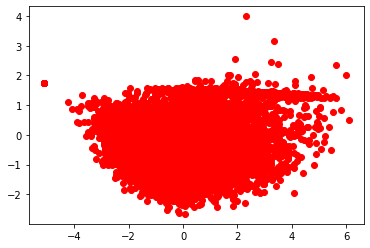

In [19]:
# this is for u

plt.scatter(*pca_res.T, c='red')
plt.show()

In [56]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 20

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    print(k)
    model = get_similarity_model(n_clusters = k).fit(user_based_scores)
    labels = model['cluster'].labels_
    sil.append(silhouette_score(imputed_user_scores, labels, metric = 'euclidean'))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


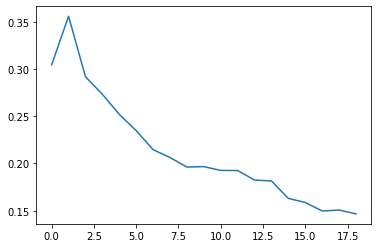

In [57]:
plt.plot(sil)

In [58]:
sil

[0.30446021726559863,
 0.35579417040517713,
 0.29171092843970897,
 0.2732150221112941,
 0.2519087085018874,
 0.23473098682561408,
 0.21460140625584528,
 0.2062943805002901,
 0.19617186523382518,
 0.19666393402818277,
 0.19265758568268865,
 0.19251594333932606,
 0.18244578161642253,
 0.1814712183648345,
 0.16301810837474043,
 0.1587235322526898,
 0.14969960715318342,
 0.15070469256934324,
 0.1466180894526452]

In [20]:
similarity_model = get_similarity_model(n_clusters=3)

In [21]:
similarity_model.fit(user_based_scores)

Pipeline(steps=[('transpose',
                 FunctionTransformer(func=<function <lambda> at 0x0000025796A29F30>)),
                ('scaler', MinMaxScaler()), ('impute', KNNImputer()),
                ('transpose2',
                 FunctionTransformer(func=<function <lambda> at 0x0000025796A29F30>)),
                ('cluster', KMeans(n_clusters=3))])

In [22]:
similarity_model['cluster'].labels_

array([1, 2, 1, ..., 1, 0, 2])

In [29]:
labels = similarity_model['cluster'].labels_

In [23]:
label_table = pd.DataFrame(similarity_model['cluster'].labels_, index=ranked_table.index)

In [24]:
label_table[label_table[0] == 2]

,0
username,
- A s u s a -,2
- Edgeworth -,2
- Fleaty -,2
- Hago -,2
- K a n o -,2
...,...
zsourlemon07,2
zureff,2
zvirtual,2


In [25]:
label_table.loc['HowToPlayLN']

0    2
Name: HowToPlayLN, dtype: int32

In [33]:
label_table[label_table['username'] == 'Polytetral']

,username,0
4153,Polytetral,1


In [27]:
label_table = label_table.reset_index()

In [28]:
label_table

,username,0
0,- A n l u -,1
1,- A s u s a -,2
2,- Abby -,1
3,- AlKaid -,0
4,- Astaroth -,1
...,...,...
9075,zyf666,0
9076,zzfzzzcr,1
9077,zznith,1
9078,zzyzheng,0


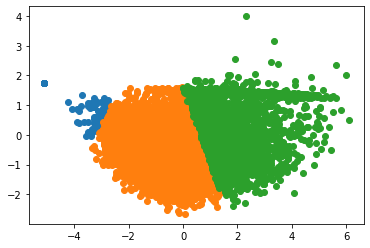

In [31]:
plt.scatter(*pca_res[labels == 0].T)
plt.scatter(*pca_res[labels == 1].T)
plt.scatter(*pca_res[labels == 2].T)
plt.show()

In [41]:
pca_res[label_table[label_table['username'] == 'DemiFiendSMT'].index]

array([[ 2.3695415 , -0.58954681]])

In [59]:
beatmap_idx = pca_model.components_.argsort(axis=1)[:, ::-1][:, :10]

In [60]:
bm_ids = ranked_table.columns[beatmap_idx]

C:\Users\HP\AppData\Local\Temp\ipykernel_9864\930080564.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  bm_ids = ranked_table.columns[beatmap_idx]


In [61]:
@np.vectorize
def get_metadata(id):
    return beatmaps_list[beatmaps_list['beatmap_id'] == id]['artist - title'].values[0]

get_metadata(bm_ids)

array([['DJ Sharpnel - Lolit Speed (IcyWorld) [Marathon]',
        'pencil - little (girl) goodbye.rah (Elekton) [parting [1.2x Rate]]',
        'Akiyama Uni - Odoru Mizushibuki (Shoegazer) [Macabre 1.1x (152bpm)]',
        'Yu_Asahina - Trickstarz (hi19hi19) [STEPMANIA]',
        'Neil Cicierega - Wallspin (Pope Gadget) [Wonderround]',
        'Camellia - K.Y.A.F.A. (Evening) [UNSTOPPABLE DOMINATION]',
        'Tatsh - IMAGE -MATERIAL- <Version 0> (Fullerene-) [Refraction]',
        "LeaF - LeaF Style Super * Shredder (Cherry Blossom) [Fullerene's 4K Shredder]",
        'Camellia - GHOST (Lynessa) [x1.1]',
        'Terminal 11 - Staple On Smile (hi19hi19) [Extreme]'],
       ['Sharkey & Arkitech - Quadraphinix (Xay) [Challenge 1.5x]',
        'Silentroom - Nhelv (Guilhermeziat) [Silent]',
        'goreshit - slavik goblins (stankill) [Extreme]',
        'The Ghost of 3.13 - Forgotten (Shoegazer) [Extra (350bpm)]',
        'Camellia - GHOST (Lynessa) [x1.3]',
        'Dev/Null - Rave 7